In [2]:
import os
import pandas as pd
import re
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
# read file
def read_file(relative_path, filename):
    # Get the absolute path of the file by joining the current working directory and the relative path
    absolute_path = os.path.join(os.getcwd(), relative_path, filename)

    # Check if the file exists
    if os.path.exists(absolute_path):
        # Open the file and read its contents
        with open(absolute_path, "r") as file:
            contents = file.read()
            return contents
    else:
        print(f"File '{relative_path}' not found.")
        return None

In [4]:
def select_lines_with_string(contents, search_string):
    matched_lines = []
    count = 0

    # Split the contents into lines
    lines = contents.split("\n")

    # Iterate over each line
    for line in lines:
        # Check if the search string is in the line
        if search_string in line:
            matched_lines.append(
                line.strip()
            )  # Append the line to the list of matched lines
            count += 1  # Increment the count of matched lines

    return matched_lines, count

In [5]:
def parse_values_using_regex(matched_lines, regex_pattern):
    parsed_values = []

    # Iterate over each line
    for line in matched_lines:
        # Search for the regular expression pattern in the line
        matches = re.findall(regex_pattern, line)
        # Append the matches to the list of parsed values
        parsed_values.extend(matches)

    return parsed_values

In [6]:
def convert_to_epoch(date_time_list):
    epoch_times = []
    for date_time_str in date_time_list:
        # Convert date-time string to datetime object
        date_time_obj = datetime.strptime(date_time_str, "%Y-%m-%d %H:%M:%S,%f")
        # Convert datetime object to epoch time (in milliseconds)
        epoch_time = int(date_time_obj.timestamp() * 1000)
        # Append epoch time to the list
        epoch_times.append(epoch_time)
    return epoch_times

In [7]:
def convert_to_float(string_list):
    float_list = []
    for string in string_list:
        try:
            # Try to convert the string to a float
            float_value = float(string)
            # Append the float value to the list
            float_list.append(float_value)
        except ValueError:
            # If conversion fails, print an error message and continue to the next string
            print(f"Unable to convert '{string}' to float.")
    return float_list

In [8]:
def construct_cdf(data_ms):
    # Create figure and axes
    fig, ax1 = plt.subplots(figsize=(8, 6))

    # Convert milliseconds to seconds
    data_sec = np.array(data_ms) / 1000.0

    # Sort the data in ascending order
    sorted_data = np.sort(data_sec)

    # Calculate the cumulative probabilities
    n = len(sorted_data)
    p50 = sorted_data[int(n * 0.50)]
    p90 = sorted_data[int(n * 0.90)]
    p95 = sorted_data[int(n * 0.95)]
    p99 = sorted_data[int(n * 0.99)]

    # getting data of the histogram
    count, bins_count = np.histogram(sorted_data, bins=200)

    # finding the PDF of the histogram using count values
    pdf = count / sum(count) 

    # using numpy np.cumsum to calculate the CDF
    # We can also find using the PDF values by looping and adding
    cdf = np.cumsum(pdf)

    # Prepend a point at (0, 0) to the CDF data
    bins_count = np.insert(bins_count, 0, 0)
    cdf = np.insert(cdf, 0, 0)

    ax1.plot(bins_count[1:], cdf, label="CDF", color="red")
    ax1.set_xlabel("Round Time (seconds)")
    ax1.set_ylabel("CDF")
    ax1.set_title("CDF of Round Training Time")

    # Annotate the plot with text for percentiles
    ymin, ymax = plt.ylim()
    xmin, xmax = plt.xlim()
    plt.text(
        xmax * 0.95,
        0.5,
        f"P50: {p50:.1f}s",
        fontsize=10,
        ha="right",
        va="center",
        color="blue",
    )
    plt.text(
        xmax * 0.95,
        0.9,
        f"P90: {p90:.1f}s",
        fontsize=10,
        ha="right",
        va="center",
        color="blue",
    )
    plt.text(
        xmax * 0.95,
        0.95,
        f"P95: {p95:.1f}s",
        fontsize=10,
        ha="right",
        va="center",
        color="blue",
    )
    plt.text(
        xmax * 0.95,
        0.99,
        f"P99: {p99:.1f}s",
        fontsize=10,
        ha="right",
        va="center",
        color="blue",
    )

    return fig

In [9]:
def smooth_line(data, smoothing):
    if smoothing == 0:
        return data
    else:
        return uniform_filter1d(data, size=int(len(data) * smoothing), mode="nearest")


def plot_dual_axis(accuracy, staleness, accuracy_smoothing=0, staleness_smoothing=0):
    # Create figure and axes
    fig, ax1 = plt.subplots(figsize=(8, 6))

    # Generate x-axis values
    x = np.arange(len(accuracy))

    # Smooth the lines
    accuracy_smoothed = smooth_line(accuracy, accuracy_smoothing)
    staleness_smoothed = smooth_line(staleness, staleness_smoothing)

    # Plot accuracy on first y-axis (left)
    color = "tab:blue"
    ax1.set_xlabel("Round number")
    ax1.set_ylabel("Accuracy", color=color)
    ax1.plot(x, accuracy_smoothed, color=color)
    ax1.tick_params(axis="y", labelcolor=color)
    ax1.set_ylim(0, 70)  # Set y-axis limits for accuracy

    # Create a second y-axis (right) for staleness
    ax2 = ax1.twinx()

    # Plot staleness on second y-axis (right)
    color = "tab:red"
    ax2.set_ylabel("Staleness", color=color)
    ax2.plot(x, staleness_smoothed, color=color)
    ax2.tick_params(axis="y", labelcolor=color)
    ax2.set_ylim(0, 2)  # Set y-axis limits for staleness

    # Title and grid
    plt.title("Smoothed Accuracy and Staleness")
    plt.grid(True)

    return fig

In [10]:
def save_plots_to_pdf(line_plot, cdf_plot, filename):
    # Create a PDF file
    with PdfPages(filename + ".pdf") as pdf:
        fig, axs = plt.subplots(1, 2, figsize=(16, 6))

        # Render line_plot onto the first subplot
        line_plot.canvas.draw()
        image_line = np.frombuffer(line_plot.canvas.buffer_rgba(), dtype=np.uint8)
        image_line = image_line.reshape(
            line_plot.canvas.get_width_height()[::-1] + (4,)
        )
        axs[0].imshow(image_line)
        axs[0].axis("off")

        # Render cdf_plot onto the second subplot
        cdf_plot.canvas.draw()
        image_cdf = np.frombuffer(cdf_plot.canvas.buffer_rgba(), dtype=np.uint8)
        image_cdf = image_cdf.reshape(cdf_plot.canvas.get_width_height()[::-1] + (4,))
        axs[1].imshow(image_cdf)
        axs[1].axis("off")

        # Set common title for the entire figure
        fig.suptitle(filename)

        # Adjust subplot spacing and use tight layout
        plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01, wspace=0.01)
        plt.tight_layout()  # Adjust layout to prevent overlap

        pdf.savefig(fig, bbox_inches="tight", pad_inches=0)
        plt.close(fig)

In [11]:
def get_epoch_time_list(file_contents):
    # read all lines with "aggregation finished for round"
    search_string = "aggregation finished for round"
    matched_lines, count = select_lines_with_string(file_contents, search_string)

    print(f"Number of lines matched: {count}")
    matched_lines[0]

    # Regular expression to match the date and time
    time_regex = r"(\b\d{4}-\d{2}-\d{2}\s+\d{2}:\d{2}:\d{2},\d{3})\b"

    parsed_datetime_values_agg_round = parse_values_using_regex(matched_lines, time_regex)
    print(
        f"Number of parsed_datetime_values_agg_round: {len(parsed_datetime_values_agg_round)}"
    )
    print(f"Example parsed value: {parsed_datetime_values_agg_round[0]}")

    # Convert date-time string list to epoch time list
    epoch_time_list = convert_to_epoch(parsed_datetime_values_agg_round)
    print(f"Number of values in epoch_time_list: {len(epoch_time_list)}")
    return epoch_time_list

In [12]:
def get_agg_staleness_list(file_contents):
    # read all lines with "aggregator avg staleness"
    search_string = "aggregator avg staleness"
    matched_lines, count = select_lines_with_string(file_contents, search_string)

    print(f"Number of lines matched: {count}")
    matched_lines[0]

    # Regular expression to match the number at the end of the line
    number_regex = r"(\d+(?:\.\d+)?)$"

    parsed_staleness_agg_round = parse_values_using_regex(matched_lines, number_regex)
    print(f"Number of parsed_staleness_agg_round: {len(parsed_staleness_agg_round)}")
    print(f"Example parsed value: {parsed_staleness_agg_round[0]}")

    staleness_float_val_list = convert_to_float(parsed_staleness_agg_round)
    print(f"Number of staleness_float_val_list: {len(staleness_float_val_list)}")

    return staleness_float_val_list

In [13]:
def get_agg_round_accuracy(file_contents):
    # read all lines with "Test accuracy"
    search_string = "Test accuracy"
    matched_lines, count = select_lines_with_string(file_contents, search_string)

    print(f"Number of lines matched: {count}")
    matched_lines[0]

    # Regular expression to match the number within brackets at the end of the line
    number_regex = r"\((\d+(?:\.\d+)?)\)"

    parsed_accuracy_agg_round = parse_values_using_regex(matched_lines, number_regex)
    print(f"Number of parsed_accuracy_agg_round: {len(parsed_accuracy_agg_round)}")
    print(f"Example parsed value: {parsed_accuracy_agg_round[0]}")

    accuracy_float_val_list = convert_to_float(parsed_accuracy_agg_round)
    accuracy_float_val_list = [i*100 for i in accuracy_float_val_list]
    print(f"Number of accuracy_float_val_list: {len(accuracy_float_val_list)}")
    print(f"Example value after getting percentage accuracy_float_val_list: {accuracy_float_val_list[0]}")

    return accuracy_float_val_list

In [14]:
def get_agg_round_durations(epoch_time_list):
    # extract per-round durations from round-epoch timestamps
    round_time_duration_ms = []
    for i in range(0, len(epoch_time_list)-1):
        curr_round_time = epoch_time_list[i+1] - epoch_time_list[i]
        round_time_duration_ms.append(curr_round_time)

    return round_time_duration_ms

In [15]:
# using the duration of rounds, construct a CDF
# label P50, P90, P95 and P99 in the CDF
# get_cdf = construct_cdf(round_time_duration_ms)

In [16]:
# in a single timeline plot, have round # on the X axis, and two Y-axis. One for accuracy and the other for staleness
# get_line_plot = plot_dual_axis(accuracy_float_val_list, staleness_float_val_list, accuracy_smoothing=0.01, staleness_smoothing=0)

In [ ]:
# make 6 plots for all completed FedBuff runs from the other day

In [21]:
def get_agg_analysis_for_run(log_filename):
    # read aggregator log file
    relative_path = "./async_cifar10/aggregator/"
    file_contents = read_file(relative_path, log_filename + ".txt")

    epoch_time_list = get_epoch_time_list(file_contents)
    round_time_duration_ms = get_agg_round_durations(epoch_time_list)

    staleness_float_val_list = get_agg_staleness_list(file_contents)
    print("staleness_float_val_list[:50]: ", staleness_float_val_list[:50])

    accuracy_float_val_list = get_agg_round_accuracy(file_contents)

    line_plot = plot_dual_axis(
        accuracy_float_val_list,
        staleness_float_val_list,
        accuracy_smoothing=0.01,
        staleness_smoothing=0,
    )

    cdf_plot = construct_cdf(round_time_duration_ms)

    save_plots_to_pdf(line_plot, cdf_plot, log_filename)

Number of lines matched: 510
Number of parsed_datetime_values_agg_round: 510
Example parsed value: 2024-02-25 16:45:11,133
Number of values in epoch_time_list: 510
Number of lines matched: 510
Number of parsed_staleness_agg_round: 510
Example parsed value: 0.0
Number of staleness_float_val_list: 510
staleness_float_val_list[:50]:  [0.0, 0.5, 0.8, 0.9, 0.96, 1.1166666666666667, 1.2142857142857142, 1.2, 1.3, 1.4, 1.4727272727272727, 1.4833333333333334, 1.4384615384615385, 1.3928571428571428, 1.4133333333333333, 1.4, 1.4411764705882353, 1.4222222222222223, 1.394736842105263, 1.435, 1.4761904761904763, 1.4363636363636363, 1.3956521739130434, 1.4041666666666666, 1.416, 1.3846153846153846, 1.4074074074074074, 1.3821428571428571, 1.3586206896551725, 1.3333333333333333, 1.3096774193548386, 1.2875, 1.2666666666666666, 1.2470588235294118, 1.2285714285714286, 1.211111111111111, 1.1945945945945946, 1.1789473684210525, 1.1641025641025642, 1.15, 1.1365853658536584, 1.1238095238095238, 1.111627906976

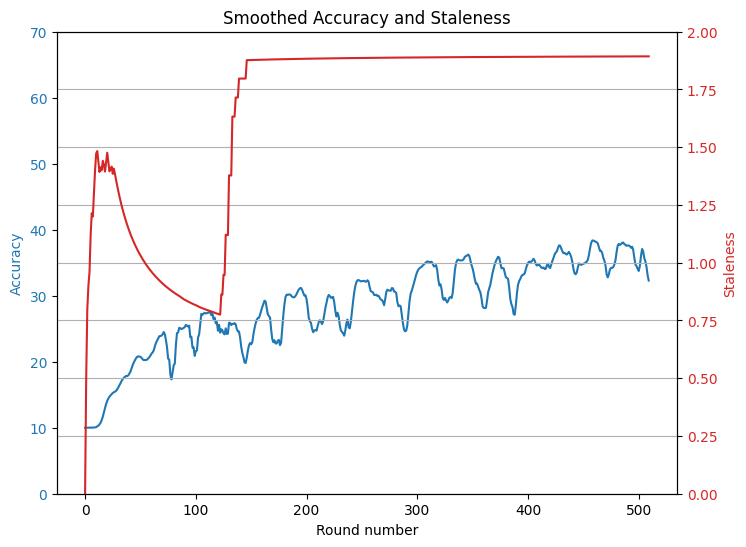

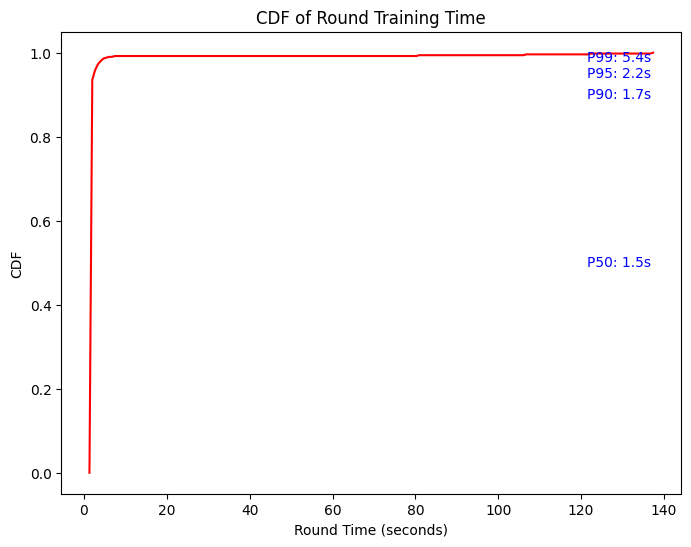

In [22]:
get_agg_analysis_for_run(
    "agg_fedbuff_config_dir100_num100_noFail_0.75K_c20_k10_n100_25feb24"
)

In [ ]:
staleness_float_val_list[:20]